#### Import Statements

In [235]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import censusgeocode as cg
from census import Census
from us import states # US state abbreviations, and a few other things
import requests

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [3]:
%%R 

library(tidycensus)
library(tidyverse)
library(ggthemes)
# library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
import pandas as pd
import os
import chardet  # Ensure you've installed chardet with pip install chardet


### Data Prep:

#### Library Data

In [236]:
df = pd.read_csv('data/1992_2021_AE.csv')
df

,LIBID,LIBNAME,ADDRESS,CITY,ZIP1,ZIP2,PHONE,POPU,CENTLIB,BRANLIB,...,GENATTEN,ONATTEN,OFFATTEN,VIRATTEN,TOTPRES,TOTVIEWS,PITUSRRPT,WIFISRPT,TOTINCM_CAP,TOTINCM_REG
0,40,ANCHOR POINT PUBLIC LIBRARY,BOX 129,ANCHOR POINT,99556,129.0,9072357345,1358.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50,ANCHORAGE MUNICIPAL LIBRARIES,3600 DENALI,ANCHORAGE,99503,6093.0,9072612975,272262.0,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60,ANDERSON VILLAGE LIBRARY,BOX 3078,ANDERSON,99744,3078.0,9075822628,649.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,70,ANIAK PUBLIC LIBRARY,BOX 270,ANIAK,99557,270.0,9076754435,529.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90,KUSKOKWIM CONSORTIUM LIBRARY,POUCH 1068,BETHEL,99559,1068.0,9075434516,4868.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274956,29,SUBLETTE COUNTY LIBRARY SYSTEM,155 S TYLER ST,PINEDALE,NaN,NaN,3073674114,NaN,1,1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,CT,M,125.325046,215.534384
274957,30,TETON COUNTY LIBRARY,125 VIRGINIAN LANE,JACKSON,NaN,NaN,3077332164,NaN,1,1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,M,CT,133.017830,204.079634
274958,31,UINTA COUNTY LIBRARY SYSTEM,701 MAIN ST,EVANSTON,NaN,NaN,3077830480,NaN,1,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,CT,CT,20.728117,38.746801
274959,32,WASHAKIE COUNTY LIBRARY,"801 BIG HORN AVE., SUITE 100",WORLAND,NaN,NaN,3073472231,NaN,1,1,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,CT,M,41.280677,48.552495


There are some years where the population of the legal service area is under the column "POPU" and some under the column "POPU_LSA". Here, I am merging the two columns together

In [237]:
df['POPU_LSA'] = df['POPU_LSA'].fillna(df['POPU'])

In [238]:
df['LOCGVT_PCT'] = df['LOCGVT'] / df['TOTINCM'] 
df['STGVT_PCT'] = df['STGVT'] / df['TOTINCM']
df['FEDGVT_PCT'] = df['FEDGVT'] / df['TOTINCM']
df['OTHINCM_PCT'] = df['OTHINCM'] / df['TOTINCM']

Filtering for Ohio

In [8]:
OH_df = df[df['STABR'] == 'OH']

#### Census Data

In [9]:
%%R -o census_ohio

# Median real estate taxes paid for housing units with mortgages in 2021

options(tigris_use_cache = TRUE)

census_ohio <- get_acs(
  state = "OH",
  geography = "county",
  variables = "B25103_001E",
  geometry = FALSE,
  year = 2021
)

Getting data from the 2017-2021 5-year ACS
Using FIPS code '39' for state 'OH'
In addition: Warning message:
• You have not set a Census API key. Users without a key are limited to 500
queries per day and may experience performance limitations.
ℹ For best results, get a Census API key at
http://api.census.gov/data/key_signup.html and then supply the key to the
`census_api_key()` function to use it throughout your tidycensus session.
This warning is displayed once per session. 


In [10]:
census_ohio['NAME'] = census_ohio['NAME'].str.replace(' County, Ohio', '').str.upper()
census_ohio['rank'] = census_ohio['estimate'].rank(ascending=False)
census_ohio.sort_values('rank', inplace=True)
census_ohio

,GEOID,NAME,variable,estimate,moe,rank
21,39041,DELAWARE,B25103_001,6125.0,96.0,1.0
28,39055,GEAUGA,B25103_001,4038.0,119.0,2.0
25,39049,FRANKLIN,B25103_001,3708.0,48.0,3.0
83,39165,WARREN,B25103_001,3657.0,68.0,4.0
29,39057,GREENE,B25103_001,3513.0,105.0,5.0
...,...,...,...,...,...,...
58,39115,MORGAN,B25103_001,1031.0,74.0,84.0
53,39105,MEIGS,B25103_001,1019.0,78.0,85.0
44,39087,LAWRENCE,B25103_001,1006.0,60.0,86.0
56,39111,MONROE,B25103_001,977.0,46.0,87.0


In [11]:
OH_subset_df = OH_df.groupby(['year', 'CNTY'])[['STGVT','TOTINCM', 'LOCGVT', 'POPU_LSA']].sum().reset_index()
OH_subset_df.sort_values(by=['year', 'POPU_LSA'], inplace=True)
OH_subset_df['STGVT_PER_CAPITA'] = OH_subset_df['STGVT'] / OH_subset_df['POPU_LSA']
OH_subset_df['LOCGVT_PER_CAPITA'] = OH_subset_df['LOCGVT'] / OH_subset_df['POPU_LSA']
OH_subset_df['TOTINCM_PER_CAPITA'] = OH_subset_df['TOTINCM'] / OH_subset_df['POPU_LSA']
OH_subset_df

,year,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA
82,1992,VINTON,202733,288001,39152,11254.0,18.014306,3.478941,25.590990
61,1992,NOBLE,242247,251289,0,11645.0,20.802662,0.000000,21.579133
58,1992,MORGAN,251328,296364,7548,14183.0,17.720369,0.532186,20.895720
23,1992,FAIRFILED,390756,490101,0,14823.0,26.361465,0.000000,33.063550
56,1992,MONROE,282340,306047,0,15370.0,18.369551,0.000000,19.911971
...,...,...,...,...,...,...,...,...,...
2613,2021,MONTGOMERY,23759576,60027629,25338111,532531.0,44.616325,47.580537,112.721380
2633,2021,SUMMIT,21573328,46293504,21694449,551395.0,39.124998,39.344660,83.957062
2587,2021,HAMILTON,46653398,87572323,37362387,830639.0,56.165672,44.980295,105.427656
2574,2021,CUYAHOGA,63690984,198592372,120635915,1265172.0,50.341759,95.351395,156.968675


In [12]:
compMedInc = OH_subset_df.merge(census_ohio, left_on='CNTY', right_on='NAME').sort_values(by='STGVT_PER_CAPITA', ascending=False).drop(columns=['NAME', 'GEOID', 'variable','moe']).rename(columns={'estimate': 'PROPERTY_TAX'}).reset_index(drop=True)
compMedInc['STGVT_PER_CAPITA'] = compMedInc['STGVT_PER_CAPITA'].replace([np.inf, -np.inf], np.nan)
compMedInc.dropna(inplace=True)
compMedInc.sort_values(by='year', inplace=True)
compMedInc

,year,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA,PROPERTY_TAX,rank
2350,1992,RICHLAND,2836155,3044712,0,126408.0,22.436515,0.000000,24.086387,1750.0,36.0
2521,1992,TUSCARAWAS,1637984,1985758,201380,84970.0,19.277204,2.370013,23.370107,1669.0,41.0
2127,1992,FRANKLIN,25012748,45536069,15744987,977563.0,25.586840,16.106366,46.581212,3708.0,3.0
2618,1992,HOCKING,438748,512993,0,25921.0,16.926353,0.000000,19.790633,1535.0,53.5
2454,1992,CRAWFORD,984312,1056565,1877,47750.0,20.613864,0.039309,22.127016,1320.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...
605,2021,WAYNE,4311806,8040109,3276267,116311.0,37.071352,28.168161,69.125955,2229.0,22.0
625,2021,PIKE,1002423,1480875,383718,27088.0,37.006165,14.165608,54.669042,1104.0,82.0
1638,2021,MEDINA,5398868,17687158,10733521,182172.0,29.636102,58.919708,97.090431,3117.0,8.0
316,2021,SANDUSKY,2127567,3498600,1167409,53842.0,39.515007,21.682125,64.979013,1547.0,52.0


In [13]:
income_df = df[['year','STABR', 'LIBNAME', 'C_LEGBAS','LOCGVT','STGVT','FEDGVT','OTHINCM', 'TOTINCM', 'LOCGVT_PCT', 'STGVT_PCT', 'FEDGVT_PCT', 'OTHINCM_PCT', 'POPU_LSA']].reset_index().drop(columns='index')

columns_of_interest = ['LOCGVT','STGVT','FEDGVT','OTHINCM', 'TOTINCM', 'LOCGVT_PCT', 'STGVT_PCT', 'FEDGVT_PCT', 'OTHINCM_PCT', 'POPU_LSA']

# replacing missing data with NaN

income_df[columns_of_interest] = income_df[columns_of_interest].applymap(lambda x: np.nan if x < 0 else x)


income_df


,year,STABR,LIBNAME,C_LEGBAS,LOCGVT,STGVT,FEDGVT,OTHINCM,TOTINCM,LOCGVT_PCT,STGVT_PCT,FEDGVT_PCT,OTHINCM_PCT,POPU_LSA
0,1992,AK,ANCHOR POINT PUBLIC LIBRARY,NaN,0.0,6482.0,0.0,2721.0,9203.0,0.000000,0.704336,0.000000,0.295664,1358.0
1,1992,AK,ANCHORAGE MUNICIPAL LIBRARIES,NaN,6894038.0,76466.0,75746.0,327940.0,7374190.0,0.934887,0.010369,0.010272,0.044471,272262.0
2,1992,AK,ANDERSON VILLAGE LIBRARY,NaN,3500.0,8705.0,0.0,2682.0,14887.0,0.235104,0.584738,0.000000,0.180157,649.0
3,1992,AK,ANIAK PUBLIC LIBRARY,NaN,8926.0,8705.0,0.0,0.0,17631.0,0.506267,0.493733,0.000000,0.000000,529.0
4,1992,AK,KUSKOKWIM CONSORTIUM LIBRARY,NaN,78362.0,13764.0,3500.0,167923.0,263549.0,0.297334,0.052226,0.013280,0.637160,4868.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274956,2021,WY,SUBLETTE COUNTY LIBRARY SYSTEM,CO,1084037.0,0.0,0.0,9800.0,1093837.0,0.991041,0.000000,0.000000,0.008959,8728.0
274957,2021,WY,TETON COUNTY LIBRARY,CO,2822034.0,0.0,0.0,281405.0,3103439.0,0.909325,0.000000,0.000000,0.090675,23331.0
274958,2021,WY,UINTA COUNTY LIBRARY SYSTEM,CO,410721.0,0.0,0.0,13169.0,423890.0,0.968933,0.000000,0.000000,0.031067,20450.0
274959,2021,WY,WASHAKIE COUNTY LIBRARY,CO,308584.0,0.0,0.0,8658.0,317242.0,0.972709,0.000000,0.000000,0.027291,7685.0


### Analysis

##### Ohio's state government has consistently allocated more funds for its libraries than any other state.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


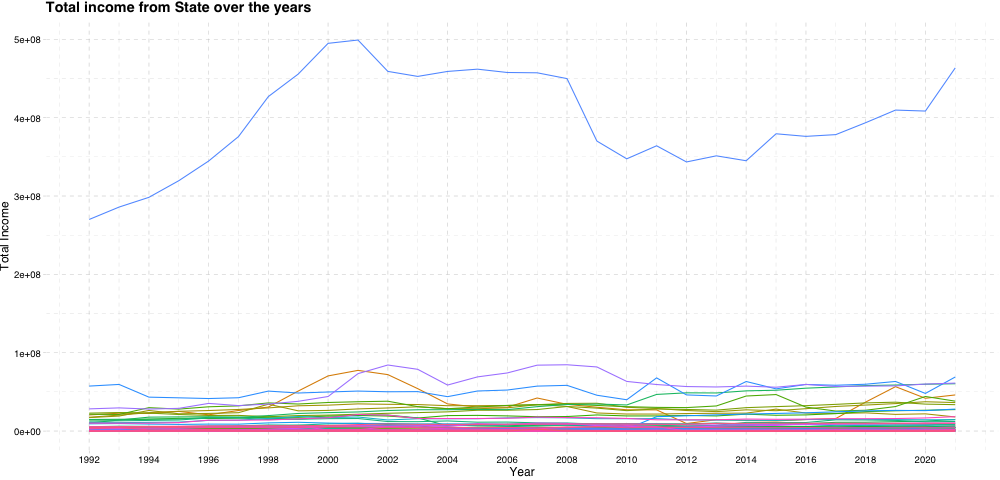

In [14]:
%%R -i income_df -w 1000 
# remove OH from the dataset
# income_df <- income_df %>% filter(STABR == 'OH')

income_df %>%
    group_by(year, STABR) %>%
    summarise(total_income = sum(STGVT, na.rm = TRUE)) %>%
    ggplot(aes(x = year, y = total_income, color = STABR)) +
    geom_line() +
    scale_x_continuous(breaks = seq(min(income_df$year), max(income_df$year), by = 2)) + # Adjusted to dynamically cover the range of years in the dataset
    labs(title = 'Total income from State over the years',
         x = 'Year',
         y = 'Total Income'
        ) +
    # geom_text(aes(label = STABR), nudge_x = 0.5, nudge_y = 0.5, check_overlap = TRUE) +
    theme_pander() + 
    # remove legend
    theme(legend.position = 'none')

In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


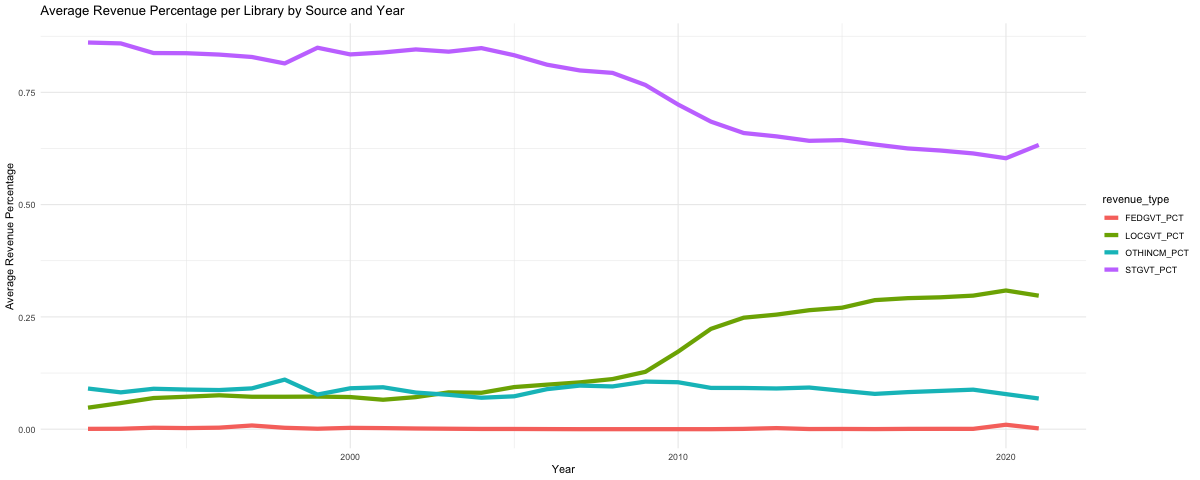

In [15]:
%%R -i OH_df -w 1200


OH_df <- OH_df %>%
  group_by(year) %>%
  summarise(
    LIBRARY_COUNT = n(), 
    LOCGVT_PCT = mean(LOCGVT_PCT, na.rm = TRUE), 
    STGVT_PCT = mean(STGVT_PCT, na.rm = TRUE), 
    FEDGVT_PCT = mean(FEDGVT_PCT, na.rm = TRUE),
    OTHINCM_PCT = mean(OTHINCM / TOTINCM, na.rm = TRUE)  # Assuming you want this as well
  )

income_long <- pivot_longer(OH_df, 
                            cols = c("LOCGVT_PCT", "STGVT_PCT", "FEDGVT_PCT", "OTHINCM_PCT"), 
                            names_to = "revenue_type", 
                            values_to = "percentage")

ggplot(income_long, aes(x = year, y = percentage, color = revenue_type)) +
  geom_line(size = 2) +
  labs(title = "Average Revenue Percentage per Library by Source and Year", 
       x = "Year", 
       y = "Average Revenue Percentage") +
  theme_minimal() 

  # ggsave('average_revenue_percentage_ohio.svg')

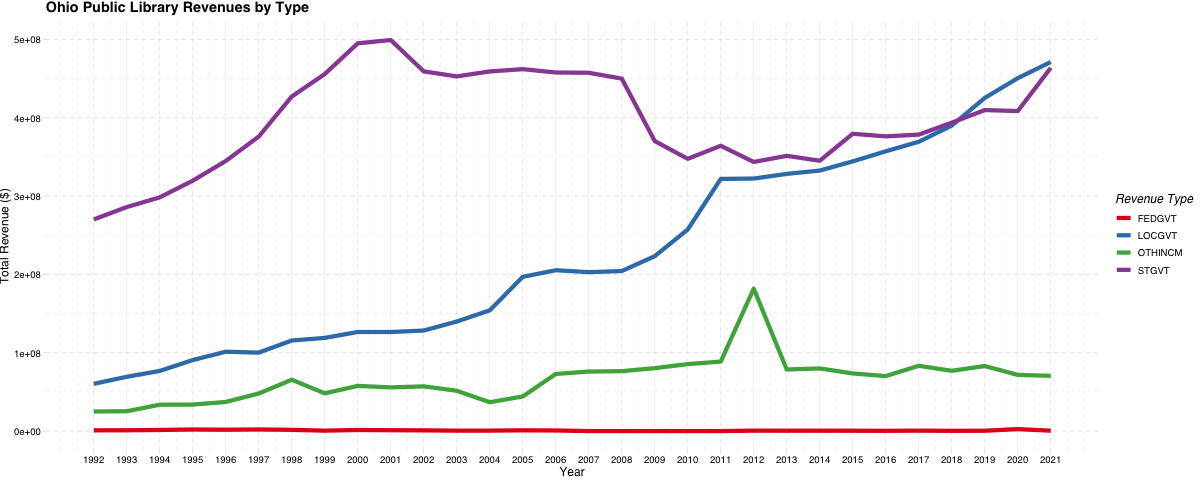

In [16]:
%%R -i OH_df -w 1200

OH_df <- OH_df %>%
  group_by(year) %>%
  summarise(
    LIBRARY_COUNT = n(), 
    LOCGVT = sum(LOCGVT, na.rm = TRUE), 
    STGVT = sum(STGVT, na.rm = TRUE), 
    FEDGVT = sum(FEDGVT, na.rm = TRUE),
    OTHINCM = sum(OTHINCM, na.rm = TRUE)
  )

income_long <- pivot_longer(OH_df, 
                            cols = c("LOCGVT", "STGVT", "FEDGVT", "OTHINCM"), 
                            names_to = "revenue_type", 
                            values_to = "total_income")

ggplot(income_long, aes(x = year, y = total_income, color = revenue_type)) +
  geom_line(size = 2) +
    labs(title = "Ohio Public Library Revenues by Type",
         x = "Year",
         y = "Total Revenue ($)",
         color = "Revenue Type") +
      #  i want to see tick marks for every year
  scale_x_continuous(breaks = seq(min(OH_df$year), max(OH_df$year), by = 1)) +
  theme_pander() +
  scale_color_brewer(palette = "Set1")  


##### Does the state distribute its funding evenly across all the counties? 

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


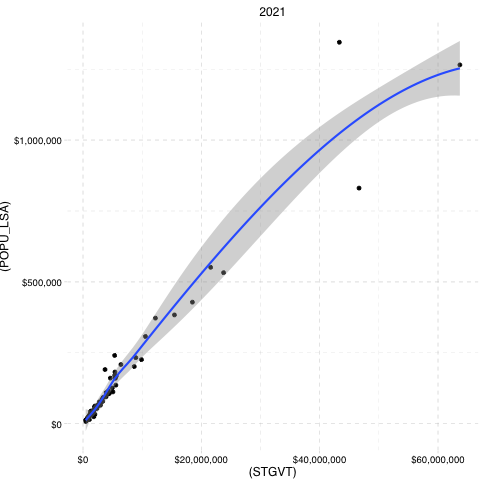

In [17]:
%%R -i compMedInc 

compMedInc <- compMedInc %>% filter(year == 2021)

ggplot(compMedInc, aes(x = (STGVT), y = (POPU_LSA))) +
    geom_point() +
    # geom_text(aes(label = CNTY), check_overlap = TRUE, vjust = 1, hjust = 1) +
    theme_minimal() +
    geom_smooth() +
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_x_continuous(labels = scales::dollar) +
    scale_y_continuous(labels = scales::dollar) +
    facet_wrap(~year, ncol = 4) +
    theme(legend.position = "none") + 
    theme_pander()

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


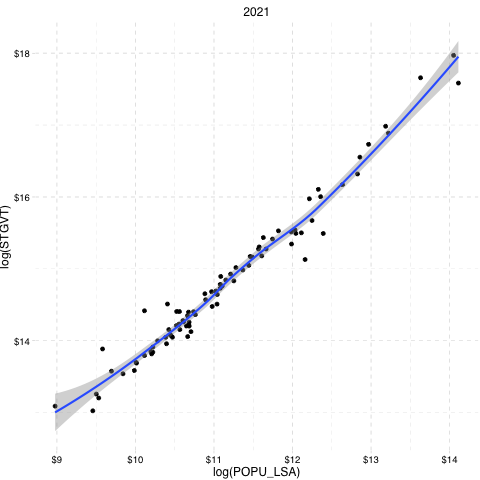

In [18]:
%%R -i compMedInc 

compMedInc <- compMedInc %>% filter(year == 2021)

ggplot(compMedInc, aes(y = log(STGVT), x = log(POPU_LSA))) +
    geom_point() +
    # geom_text(aes(label = CNTY), check_overlap = TRUE, vjust = 1, hjust = 1) +
    theme_minimal() +
    geom_smooth() +
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_x_continuous(labels = scales::dollar) +
    scale_y_continuous(labels = scales::dollar) +
    facet_wrap(~year, ncol = 4) +
    # geom_text(aes(label = CNTY), check_overlap = FALSE, vjust = 1, hjust = 1) +
    theme(legend.position = "none") + 
    theme_pander()

In [19]:
%%R -i compMedInc

model <- lm(log(STGVT) ~ log(POPU_LSA), data = compMedInc)
summary(model)


Call:
lm(formula = log(STGVT) ~ log(POPU_LSA), data = compMedInc)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90527 -0.13379  0.02399  0.17164  0.93232 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.018665   0.051556   58.55   <2e-16 ***
log(POPU_LSA) 1.036947   0.004606  225.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2332 on 2638 degrees of freedom
Multiple R-squared:  0.9505,	Adjusted R-squared:  0.9505 
F-statistic: 5.069e+04 on 1 and 2638 DF,  p-value: < 2.2e-16



In [20]:
compMedInc

,year,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA,PROPERTY_TAX,rank
2350,1992,RICHLAND,2836155,3044712,0,126408.0,22.436515,0.000000,24.086387,1750.0,36.0
2521,1992,TUSCARAWAS,1637984,1985758,201380,84970.0,19.277204,2.370013,23.370107,1669.0,41.0
2127,1992,FRANKLIN,25012748,45536069,15744987,977563.0,25.586840,16.106366,46.581212,3708.0,3.0
2618,1992,HOCKING,438748,512993,0,25921.0,16.926353,0.000000,19.790633,1535.0,53.5
2454,1992,CRAWFORD,984312,1056565,1877,47750.0,20.613864,0.039309,22.127016,1320.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...
605,2021,WAYNE,4311806,8040109,3276267,116311.0,37.071352,28.168161,69.125955,2229.0,22.0
625,2021,PIKE,1002423,1480875,383718,27088.0,37.006165,14.165608,54.669042,1104.0,82.0
1638,2021,MEDINA,5398868,17687158,10733521,182172.0,29.636102,58.919708,97.090431,3117.0,8.0
316,2021,SANDUSKY,2127567,3498600,1167409,53842.0,39.515007,21.682125,64.979013,1547.0,52.0


In [21]:
tax_data = pd.read_csv('data/taxDistribution.csv')
# guaranteed column is a string with a dollar sign and commas, so we need to remove those and convert the column to a float
tax_data['guaranteed'] = tax_data['guaranteed'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['excess'] = tax_data['excess'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['entitlement'] = tax_data['entitlement'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['entitlement_cap'] = tax_data['entitlement_cap'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['guaranteed_capita'] = tax_data['guaranteed_capita'].str.replace('$', '').str.replace(',', '').astype(float)
tax_data['excess_capita'] = tax_data['excess']/tax_data['population']
tax_data

,County,guaranteed,excess,entitlement,population,entitlement_cap,guaranteed_capita,prop_Tax,income_per_capita,excess_capita
0,CUYAHOGA,61404121.0,4798156.0,66202277.0,1265172,52.33,48.53,3421,156.968675,3.792493
1,HAMILTON,44978273.0,3514630.0,48492903.0,830639,58.38,54.15,3023,105.427656,4.231236
2,FRANKLIN,41432469.0,3237559.0,44670028.0,1344785,33.22,30.81,3708,92.165969,2.407492
3,MONTGOMERY,22906470.0,1789926.0,24696396.0,532531,46.38,43.01,2762,112.721380,3.361168
4,SUMMIT,20903237.0,1633392.0,22536629.0,551395,40.87,37.91,2739,83.957062,2.962290
...,...,...,...,...,...,...,...,...,...,...
83,HARRISON,657358.0,51366.0,708724.0,16234,43.66,40.49,1061,91.142540,3.164100
84,MONROE,552385.0,43164.0,595549.0,13385,44.49,41.27,977,43.654912,3.224804
85,MORGAN,523299.0,40890.0,564189.0,13802,40.88,37.91,1031,67.014491,2.962614
86,NOBLE,466961.0,36489.0,503450.0,7923,63.54,58.94,971,62.664900,4.605452


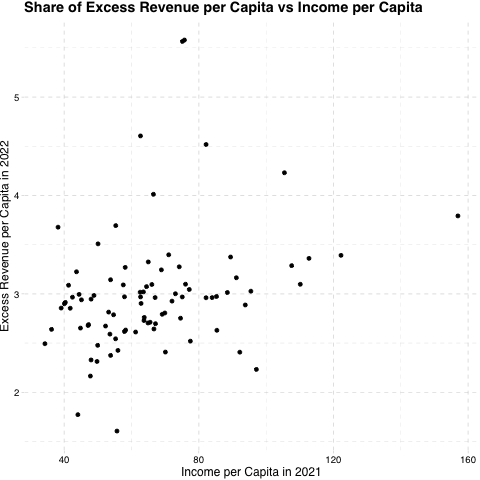

In [22]:
%%R -i tax_data

ggplot(tax_data, aes(x = income_per_capita, y = excess_capita)) +
    geom_point() +
    # geom_smooth() +
    labs(title = "Share of Excess Revenue per Capita vs Income per Capita",
         x = "Income per Capita in 2021",
         y = "Excess Revenue per Capita in 2022") +
    theme_pander() +
    theme(legend.position = 'none')

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


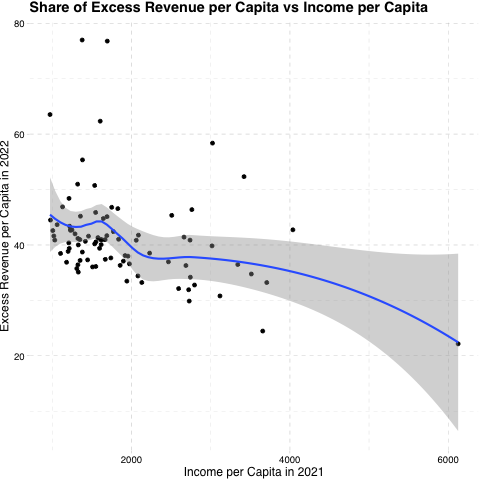

In [23]:
%%R -i tax_data

ggplot(tax_data, aes(x = prop_Tax, y = entitlement_cap)) +
    geom_point() +
    geom_smooth() +
    labs(title = "Share of Excess Revenue per Capita vs Income per Capita",
         x = "Income per Capita in 2021",
         y = "Excess Revenue per Capita in 2022") +
    theme_pander() +
    theme(legend.position = 'none')

Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


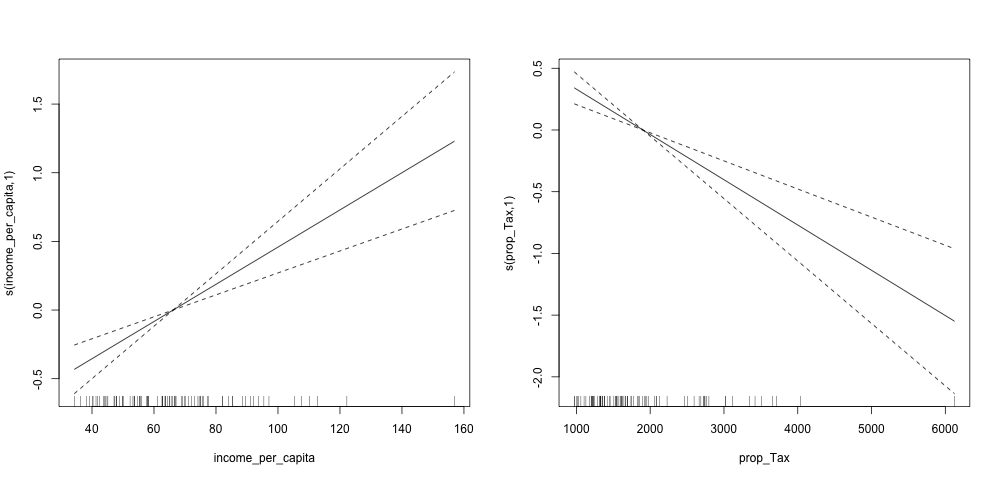

In [24]:
%%R -i tax_data -w 1000

library(mgcv)

model <- gam(excess_capita ~ s(income_per_capita) + s(prop_Tax), data = tax_data)
summary(model)

# plot the model
plot(model, pages = 1, scale = 0)

##### Is there a relationship between Ohio's library funding and the overall US/Ohio economy? Is it true that “when Ohio does well, the libraries do well?”

In [25]:
ohio_gdp = pd.read_csv('data/ohio-gdp.csv')
ohio_gdp

,year,PCT_GDP_US,PCT_GDP_OHIO,PCT_STGVT,PCT_LOCGVT,PCT_TOTINCM
0,1993,2.75,4.120187,5.8482,14.923,7.0702
1,1994,4.03,5.600573,4.3543,10.728,7.4914
2,1995,2.68,4.814601,7.1132,18.105,8.7553
3,1996,3.77,4.667548,7.8619,11.774,8.7065
4,1997,4.45,5.823223,9.0592,-1.145,8.4980
5,1998,4.48,5.773373,13.5830,15.450,15.8919
6,1999,4.79,2.986887,6.7283,2.866,2.2455
7,2000,4.08,5.336736,8.6020,6.330,9.1602
8,2001,0.95,2.901926,0.8541,0.009,0.2956
9,2002,1.70,1.576547,-8.0209,1.469,-5.4262


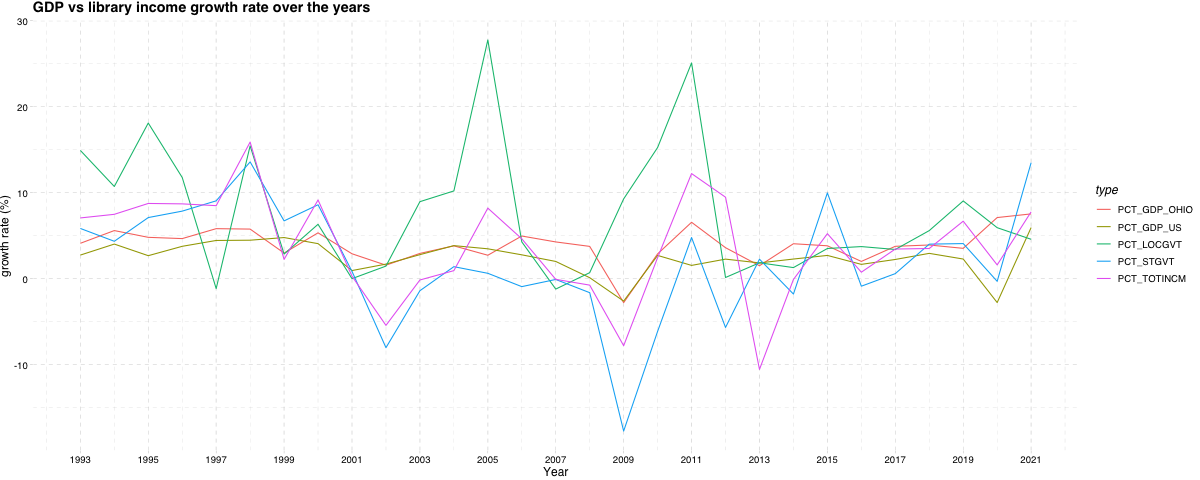

In [26]:
%%R -i ohio_gdp -w 1200

ohio_gdp %>% pivot_longer(cols = -c('year'), names_to = 'type', values_to = 'pct') %>%
    ggplot(aes(x = year, y = pct, color = type)) +
    geom_line() +
    theme_pander() + 
    labs(title = 'GDP vs library income growth rate over the years',
         x = 'Year',
         y = 'growth rate (%)'
        ) +
    scale_x_continuous(breaks = seq(min(ohio_gdp$year), max(ohio_gdp$year), by = 2))  # Adjusted to dynamically cover the range of years in the dataset


In [27]:
%%R -i ohio_gdp -w 1200

model = lm(PCT_TOTINCM ~ PCT_GDP_US+ PCT_GDP_OHIO + PCT_LOCGVT, data = ohio_gdp)
# model = lm(PCT_TOTINCM ~ PCT_GDP_US + PCT_GDP_OHIO, data = ohio_gdp)

summary(model)


Call:
lm(formula = PCT_TOTINCM ~ PCT_GDP_US + PCT_GDP_OHIO + PCT_LOCGVT, 
    data = ohio_gdp)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2882 -2.1122 -0.0957  1.8024  8.5440 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.72021    1.53857  -4.368 0.000192 ***
PCT_GDP_US    0.81160    0.37586   2.159 0.040617 *  
PCT_GDP_OHIO  1.59743    0.35706   4.474 0.000146 ***
PCT_LOCGVT    0.29672    0.08663   3.425 0.002129 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.396 on 25 degrees of freedom
Multiple R-squared:  0.6966,	Adjusted R-squared:  0.6602 
F-statistic: 19.13 on 3 and 25 DF,  p-value: 1.168e-06



In [28]:
%%R -i ohio_gdp -w 1200

model = lm(PCT_STGVT ~ PCT_GDP_US+ PCT_GDP_OHIO , data = ohio_gdp)
# model = lm(PCT_TOTINCM ~ PCT_GDP_US + PCT_GDP_OHIO, data = ohio_gdp)

summary(model)


Call:
lm(formula = PCT_STGVT ~ PCT_GDP_US + PCT_GDP_OHIO, data = ohio_gdp)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8877 -2.2956  0.3849  2.4799  7.6553 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -8.9111     1.5901  -5.604 6.88e-06 ***
PCT_GDP_US     1.6447     0.4092   4.019 0.000445 ***
PCT_GDP_OHIO   1.7682     0.3888   4.548 0.000111 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.707 on 26 degrees of freedom
Multiple R-squared:  0.7089,	Adjusted R-squared:  0.6865 
F-statistic: 31.66 on 2 and 26 DF,  p-value: 1.077e-07



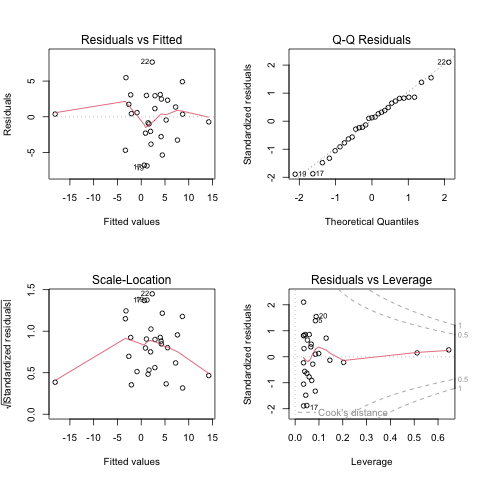

In [29]:
%%R -i ohio_gdp

par(mfrow = c(2, 2))
plot(model)

##### Libraries with lower reliance on state funding and a higher reliance on local levies have higher income per capita

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


In addition: Warning message:
The following aesthetics were dropped during statistical transformation:
colour.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 


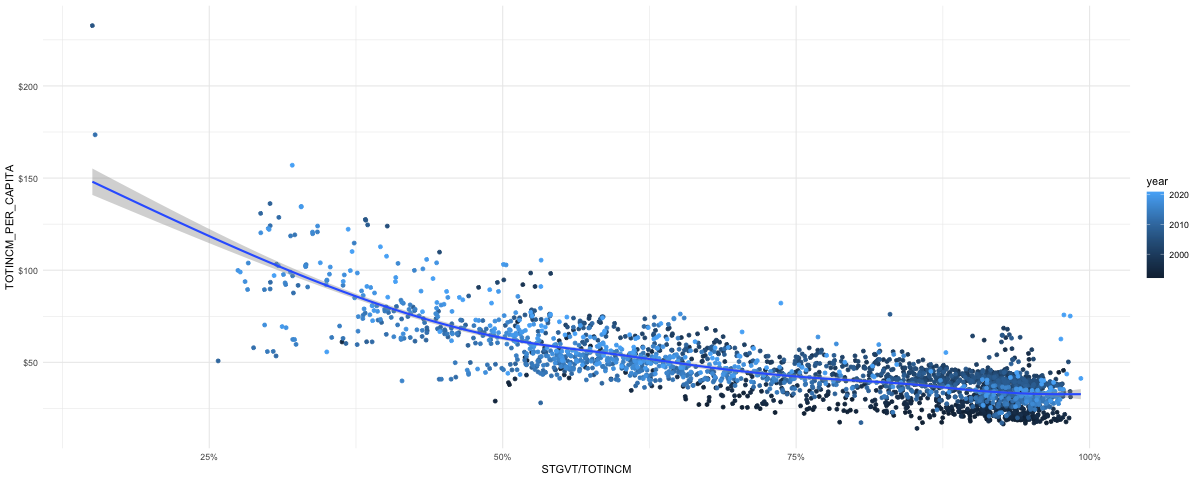

In [30]:
%%R -i compMedInc -w 1200 

plot <- ggplot(compMedInc, aes(x = STGVT/TOTINCM, y = TOTINCM_PER_CAPITA, color = year)) +
            geom_point() +
            # geom_text(aes(label = CNTY), check_overlap = TRUE, vjust = 1, hjust = 1) +
            theme_minimal() +
            geom_smooth( ) +
            theme(plot.title = element_text(hjust = 0.5)) +
            scale_x_continuous(labels = scales::percent) +
            scale_y_continuous(labels = scales::dollar) +
            # facet_wrap(~year, ncol = 1) +
            theme(legend.position = "none") + 
            theme_minimal()

print(plot)

In [31]:
compMedInc['LOCPCT'] = compMedInc['LOCGVT'] / compMedInc['TOTINCM']
compMedInc['STGPCT'] = compMedInc['STGVT'] / compMedInc['TOTINCM']


Family: gaussian 
Link function: identity 

Formula:
TOTINCM_PER_CAPITA ~ s(LOCPCT) + s(year)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  44.9830     0.1837   244.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df     F p-value    
s(LOCPCT) 7.996  8.730 517.8  <2e-16 ***
s(year)   8.840  8.992 145.2  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.735   Deviance explained = 73.7%
GCV = 89.712  Scale est. = 89.106    n = 2640


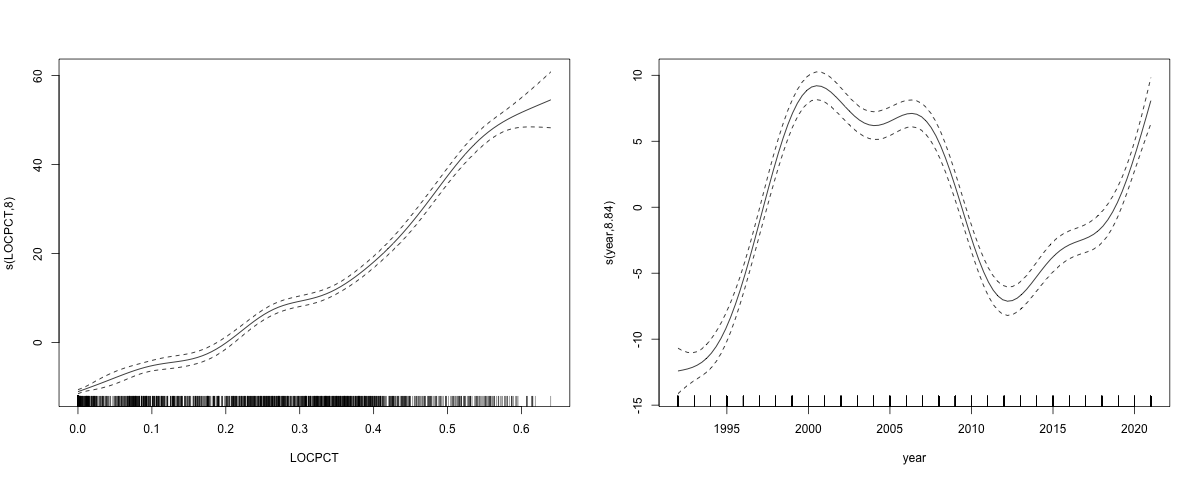

In [32]:
%%R -i compMedInc -w 1200 
library(mgcv)
library(dplyr)



gam_model <- gam(TOTINCM_PER_CAPITA ~ s(LOCPCT) + s(year), data = compMedInc)
print(summary(gam_model))

plot(gam_model, pages = 1, scale = 0)

NULL
$uniformity

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.14753, p-value < 2.2e-16
alternative hypothesis: two-sided


$dispersion

	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 0.99235, p-value = 0.792
alternative hypothesis: two.sided


$outliers

	DHARMa outlier test based on exact binomial test with approximate
	expectations

data:  simulationOutput
outliers at both margin(s) = 57, observations = 2640, p-value =
5.653e-11
alternative hypothesis: true probability of success is not equal to 0.007968127
95 percent confidence interval:
 0.01639276 0.02788398
sample estimates:
frequency of outliers (expected: 0.00796812749003984 ) 
                                            0.02159091 


$uniformity

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.14753, p-value < 2.2e-16
alternative hypothesis: two-sided


$dispersi

This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Registered S3 method overwritten by 'mgcViz':
  method from  
  +.gg   GGally


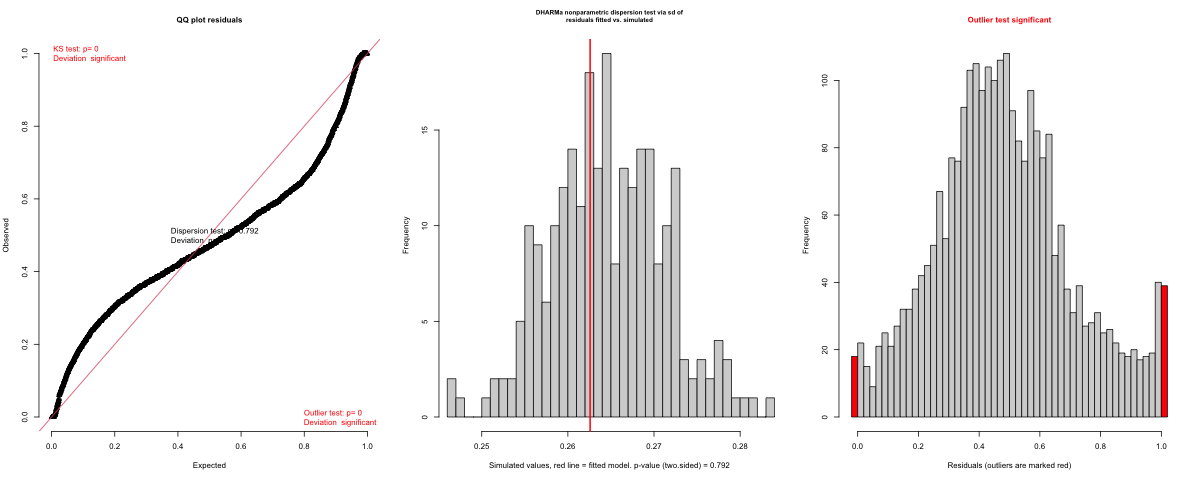

In [33]:
%%R -i compMedInc -w 1200 
library(mgcv)
library(dplyr)

library(DHARMa)

simulationOutput <- simulateResiduals(fittedModel = gam_model)
print(plot(simulationOutput))
testResiduals(simulationOutput)


##### Is % Local Gvt Funding Higher in Areas with Higher Property Tax


Family: gaussian 
Link function: identity 

Formula:
LOCPCT ~ s(PROPERTY_TAX) + s(year)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.149619   0.002322   64.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df     F p-value    
s(PROPERTY_TAX) 8.195  8.809 126.4  <2e-16 ***
s(year)         8.271  8.854 210.9  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.53   Deviance explained = 53.3%
GCV = 0.014326  Scale est. = 0.014231  n = 2640


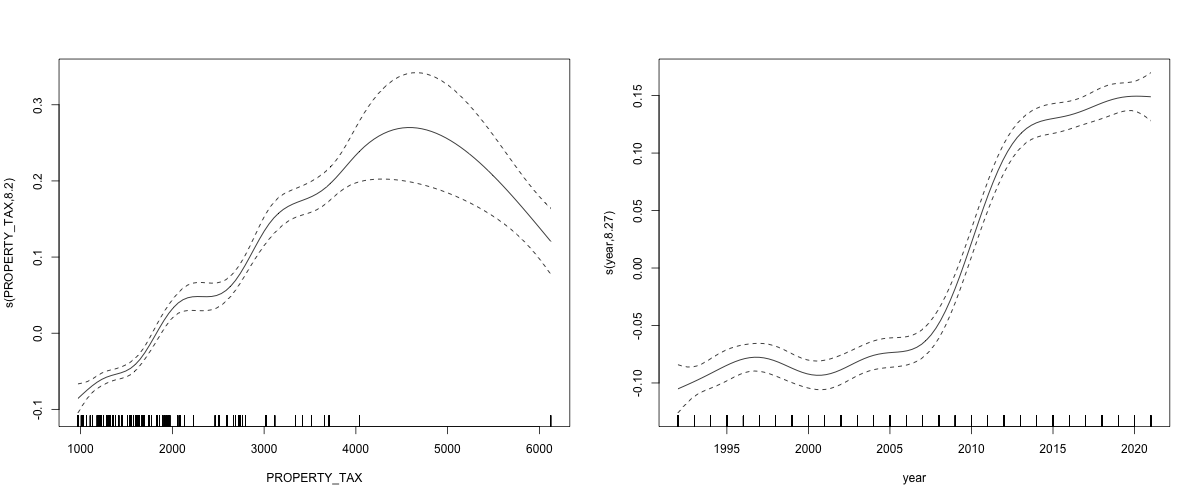

In [34]:
%%R -i compMedInc -h 500 -w 1200
library(mgcv)
library(dplyr)

# compMedInc$PROPERTY_TAX_log <- log(compMedInc$PROPERTY_TAX + 1)
gam_model_log <- gam(LOCPCT ~ s(PROPERTY_TAX) + s(year) , data = compMedInc)

# gam_model <- gam(LOCGVT_PER_CAPITA ~ s(PROPERTY_TAX) + s(year) + s(STRATIO), data = compMedInc)

print(summary(gam_model_log))


par(mfrow=c(3, 3)) 
plot(gam_model_log, pages=1, all.terms=TRUE, se=TRUE, scale=0)

par(mfrow=c(1,1))


NULL
$uniformity

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.07747, p-value = 3.464e-14
alternative hypothesis: two-sided


$dispersion

	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 0.99249, p-value = 0.8
alternative hypothesis: two.sided


$outliers

	DHARMa outlier test based on exact binomial test with approximate
	expectations

data:  simulationOutput
outliers at both margin(s) = 17, observations = 2640, p-value = 0.4431
alternative hypothesis: true probability of success is not equal to 0.007968127
95 percent confidence interval:
 0.003755526 0.010290136
sample estimates:
frequency of outliers (expected: 0.00796812749003984 ) 
                                           0.006439394 


$uniformity

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.07747, p-value = 3.464e-14
alternative hypothesis: two-sided


$dispers

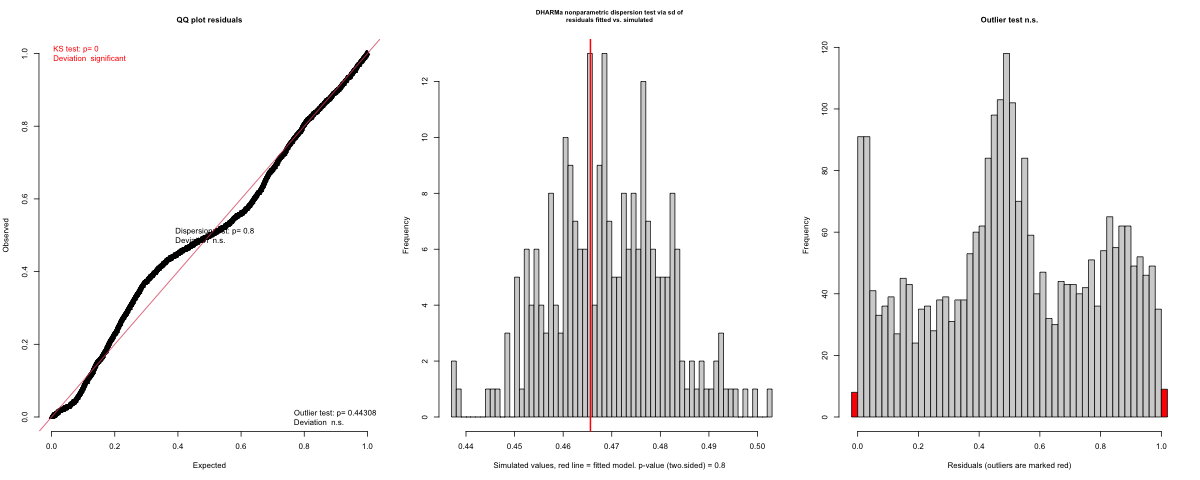

In [35]:
%%R -i compMedInc -w 1200 
library(mgcv)
library(dplyr)

library(DHARMa)

simulationOutput <- simulateResiduals(fittedModel = gam_model_log)
print(plot(simulationOutput))
testResiduals(simulationOutput)


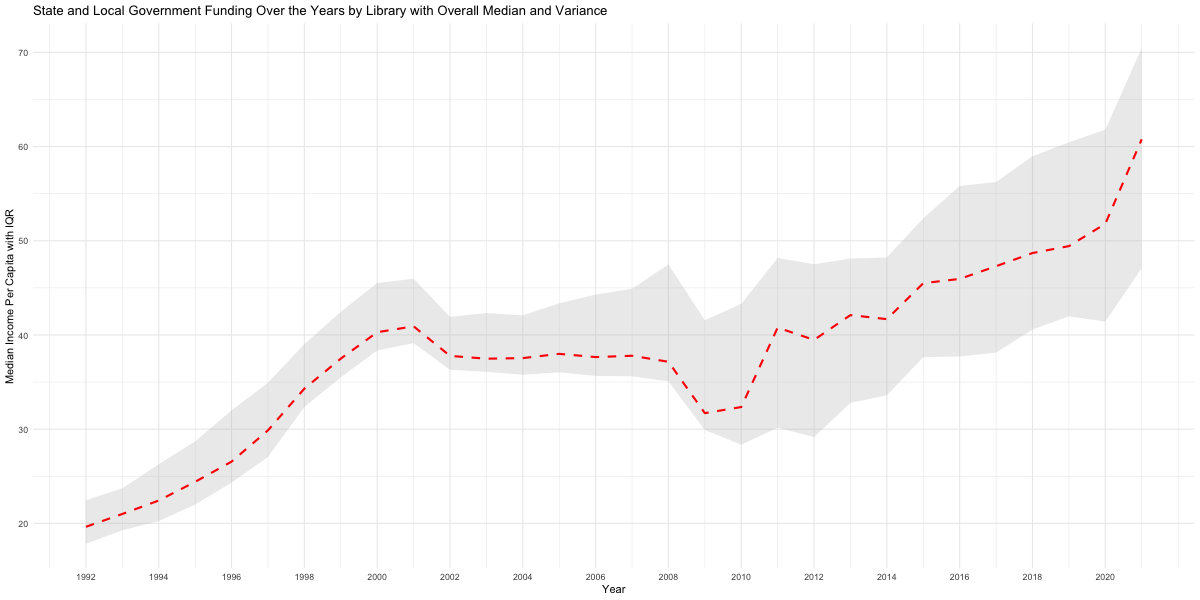

In [36]:
%%R -i compMedInc -w 1200 -h 600 -o combined_data_with_spread

library(ggplot2)
library(dplyr)

# Calculate median total income per year across all libraries
median_income_overall <- compMedInc %>%
  group_by(year) %>%
  summarise(total_income_overall = median((STGVT + LOCGVT )/POPU_LSA, na.rm = TRUE))

# Calculate median total income per year for each library
median_income_by_lib <- compMedInc %>%
  group_by(year, rank) %>%
  summarise(total_income_lib = median((STGVT + LOCGVT )/POPU_LSA, na.rm = TRUE), .groups = 'drop')

# Merge the overall median data with the per-library median data
combined_data <- left_join(median_income_by_lib, median_income_overall, by = "year")

# Calculate IQR or standard deviation for each year
spread_data <- compMedInc %>%
  group_by(year) %>%
  summarise(
    lower_bound = quantile((STGVT + LOCGVT)/POPU_LSA, 0.25, na.rm = TRUE),
    upper_bound = quantile((STGVT + LOCGVT)/POPU_LSA, 0.75, na.rm = TRUE)
  )

# Merge spread data with overall median data for plotting
combined_data_with_spread <- left_join(median_income_overall, spread_data, by = "year")

# Plot
ggplot() +
  geom_ribbon(data = combined_data_with_spread, aes(x = year, ymin = lower_bound, ymax = upper_bound), fill = "grey", alpha = 0.3) +
  geom_line(data = median_income_overall, aes(x = year, y = total_income_overall), color = "red", size = 1, linetype = "dashed") +
  scale_x_continuous(breaks = seq(min(combined_data_with_spread$year), max(combined_data_with_spread$year), by = 2)) +
  labs(title = 'State and Local Government Funding Over the Years by Library with Overall Median and Variance',
       x = 'Year',
       y = 'Median Income Per Capita with IQR') +
  theme_minimal() 
# ggsave("data/median_income_over_time.svg", width = 12, height = 8, units = "in", dpi = 300)

##### Adjusting the data for Inflation
https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-

In [468]:
cpi_years = list(range(1992, 2022))

cpi_dict = dict(zip(cpi_years, cpi_values))
compMedInc['CPI'] = compMedInc['year'].map(cpi_dict)

compMedInc['STLOC'] = compMedInc['STGVT'] + compMedInc['LOCGVT']

# Adjust STGVT and LOCGVT for inflation
compMedInc['Adjusted_STLOC'] = compMedInc['STLOC'] / compMedInc['CPI']
compMedInc['Adjusted_STGVT'] = compMedInc['STGVT'] / compMedInc['CPI'] 

In [469]:
compMedInc

,year,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA,PROPERTY_TAX,rank,LOCPCT,STGPCT,CPI,Adjustment_Factor,STLOC,Adjusted_STLOC,Adjusted_STGVT,PCT_TOTINCM
2350,1992,RICHLAND,2836155,3044712,0,126408.0,22.436515,0.000000,24.086387,1750.0,36.0,0.000000,0.931502,59.201098,1.931575,2836155,47907.135028,47907.135028,NaN
2521,1992,TUSCARAWAS,1637984,1985758,201380,84970.0,19.277204,2.370013,23.370107,1669.0,41.0,0.101412,0.824866,59.201098,1.931575,1839364,31069.761530,27668.135437,NaN
2127,1992,FRANKLIN,25012748,45536069,15744987,977563.0,25.586840,16.106366,46.581212,3708.0,3.0,0.345770,0.549295,59.201098,1.931575,40757735,688462.483213,422504.798171,NaN
2618,1992,HOCKING,438748,512993,0,25921.0,16.926353,0.000000,19.790633,1535.0,53.5,0.000000,0.855271,59.201098,1.931575,438748,7411.146316,7411.146316,NaN
2454,1992,CRAWFORD,984312,1056565,1877,47750.0,20.613864,0.039309,22.127016,1320.0,69.0,0.001777,0.931615,59.201098,1.931575,986189,16658.288981,16626.583488,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2021,WAYNE,4311806,8040109,3276267,116311.0,37.071352,28.168161,69.125955,2229.0,22.0,0.407490,0.536287,114.325027,1.000000,7588073,66372.807243,37715.328846,8.264714
625,2021,PIKE,1002423,1480875,383718,27088.0,37.006165,14.165608,54.669042,1104.0,82.0,0.259116,0.676913,114.325027,1.000000,1386141,12124.563035,8768.185092,9.412727
1638,2021,MEDINA,5398868,17687158,10733521,182172.0,29.636102,58.919708,97.090431,3117.0,8.0,0.606854,0.305242,114.325027,1.000000,16132389,141109.863527,47223.850521,3.663314
316,2021,SANDUSKY,2127567,3498600,1167409,53842.0,39.515007,21.682125,64.979013,1547.0,52.0,0.333679,0.608120,114.325027,1.000000,3294976,28821.125853,18609.809683,3.442281


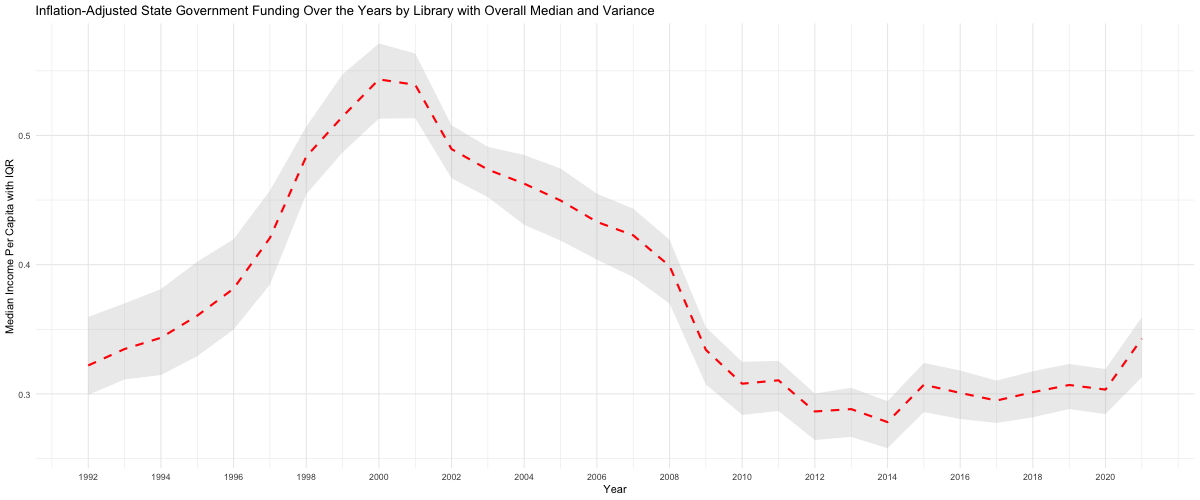

In [470]:
%%R -i compMedInc -w 1200 -h 500 

library(ggplot2)
library(dplyr)

# Calculate median total income per year across all libraries
median_income_overall <- compMedInc %>%
  group_by(year) %>%
  summarise(total_income_overall = median((Adjusted_STGVT)/POPU_LSA, na.rm = TRUE))

# Calculate median total income per year for each library
median_income_by_lib <- compMedInc %>%
  group_by(year, rank) %>%
  summarise(total_income_lib = median((Adjusted_STGVT)/POPU_LSA, na.rm = TRUE), .groups = 'drop')

# Merge the overall median data with the per-library median data
combined_data <- left_join(median_income_by_lib, median_income_overall, by = "year")

# Calculate IQR or standard deviation for each year
spread_data <- compMedInc %>%
  group_by(year) %>%
  summarise(
    lower_bound = quantile((Adjusted_STGVT)/POPU_LSA, 0.25, na.rm = TRUE),
    upper_bound = quantile((Adjusted_STGVT)/POPU_LSA, 0.75, na.rm = TRUE)
  )

# Merge spread data with overall median data for plotting
combined_data_with_spread <- left_join(median_income_overall, spread_data, by = "year")

# Plot
ggplot() +
  geom_ribbon(data = combined_data_with_spread, aes(x = year, ymin = lower_bound, ymax = upper_bound), fill = "grey", alpha = 0.3) +
  geom_line(data = median_income_overall, aes(x = year, y = total_income_overall), color = "red", size = 1, linetype = "dashed") +
  scale_x_continuous(breaks = seq(min(combined_data_with_spread$year), max(combined_data_with_spread$year), by = 2)) +
  labs(title = 'Inflation-Adjusted State Government Funding Over the Years by Library with Overall Median and Variance',
       x = 'Year',
       y = 'Median Income Per Capita with IQR') +
  theme_minimal() 
# ggsave("data/median_income_over_time.svg", width = 12, height = 8, units = "in", dpi = 300)

##### Are libraries in richer counties less affected by economic downturn? (using property tax)

In [60]:
compMedInc['PCT_TOTINCM'] = compMedInc[['year', 'CNTY','TOTINCM', 'PROPERTY_TAX']].sort_values(by=['CNTY', 'year']).groupby('CNTY')['TOTINCM'].pct_change() * 100
compMedInc

,year,CNTY,STGVT,TOTINCM,LOCGVT,POPU_LSA,STGVT_PER_CAPITA,LOCGVT_PER_CAPITA,TOTINCM_PER_CAPITA,PROPERTY_TAX,rank,LOCPCT,STGPCT,CPI,Adjustment_Factor,STLOC,Adjusted_STLOC,Adjusted_STGVT,PCT_TOTINCM
2350,1992,RICHLAND,2836155,3044712,0,126408.0,22.436515,0.000000,24.086387,1750.0,36.0,0.000000,0.931502,140.3,1.931575,2836155,5.478247e+06,5.478247e+06,NaN
2521,1992,TUSCARAWAS,1637984,1985758,201380,84970.0,19.277204,2.370013,23.370107,1669.0,41.0,0.101412,0.824866,140.3,1.931575,1839364,3.552870e+06,3.163889e+06,NaN
2127,1992,FRANKLIN,25012748,45536069,15744987,977563.0,25.586840,16.106366,46.581212,3708.0,3.0,0.345770,0.549295,140.3,1.931575,40757735,7.872663e+07,4.831400e+07,NaN
2618,1992,HOCKING,438748,512993,0,25921.0,16.926353,0.000000,19.790633,1535.0,53.5,0.000000,0.855271,140.3,1.931575,438748,8.474748e+05,8.474748e+05,NaN
2454,1992,CRAWFORD,984312,1056565,1877,47750.0,20.613864,0.039309,22.127016,1320.0,69.0,0.001777,0.931615,140.3,1.931575,986189,1.904898e+06,1.901273e+06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2021,WAYNE,4311806,8040109,3276267,116311.0,37.071352,28.168161,69.125955,2229.0,22.0,0.407490,0.536287,271.0,1.000000,7588073,7.588073e+06,4.311806e+06,8.264714
625,2021,PIKE,1002423,1480875,383718,27088.0,37.006165,14.165608,54.669042,1104.0,82.0,0.259116,0.676913,271.0,1.000000,1386141,1.386141e+06,1.002423e+06,9.412727
1638,2021,MEDINA,5398868,17687158,10733521,182172.0,29.636102,58.919708,97.090431,3117.0,8.0,0.606854,0.305242,271.0,1.000000,16132389,1.613239e+07,5.398868e+06,3.663314
316,2021,SANDUSKY,2127567,3498600,1167409,53842.0,39.515007,21.682125,64.979013,1547.0,52.0,0.333679,0.608120,271.0,1.000000,3294976,3.294976e+06,2.127567e+06,3.442281


In [105]:
df_growth = ohio_gdp[['year', 'PCT_GDP_OHIO']].merge(compMedInc[['year', 'CNTY', 'PCT_TOTINCM', 'rank']], on='year')

The following dataframe is the Percent growth of Ohio's GDP year over year, and the pct growth of each county's library income.

In [115]:
df_growth2=  df_growth
df_growth2.sort_values(by='rank')

,year,PCT_GDP_OHIO,CNTY,PCT_TOTINCM,rank
827,2002,1.576547,DELAWARE,-9.675259,1.0
2201,2018,3.922781,DELAWARE,12.679163,1.0
299,1996,4.667548,DELAWARE,9.063042,1.0
484,1998,5.773373,DELAWARE,19.374012,1.0
1389,2008,3.760990,DELAWARE,-3.341596,1.0
...,...,...,...,...,...
782,2001,2.901926,NOBLE,3.348313,88.0
2163,2017,3.770332,NOBLE,-0.671035,88.0
419,1997,5.823223,NOBLE,11.160131,88.0
1387,2008,3.760990,NOBLE,-22.802445,88.0


`geom_smooth()` using formula = 'y ~ x'


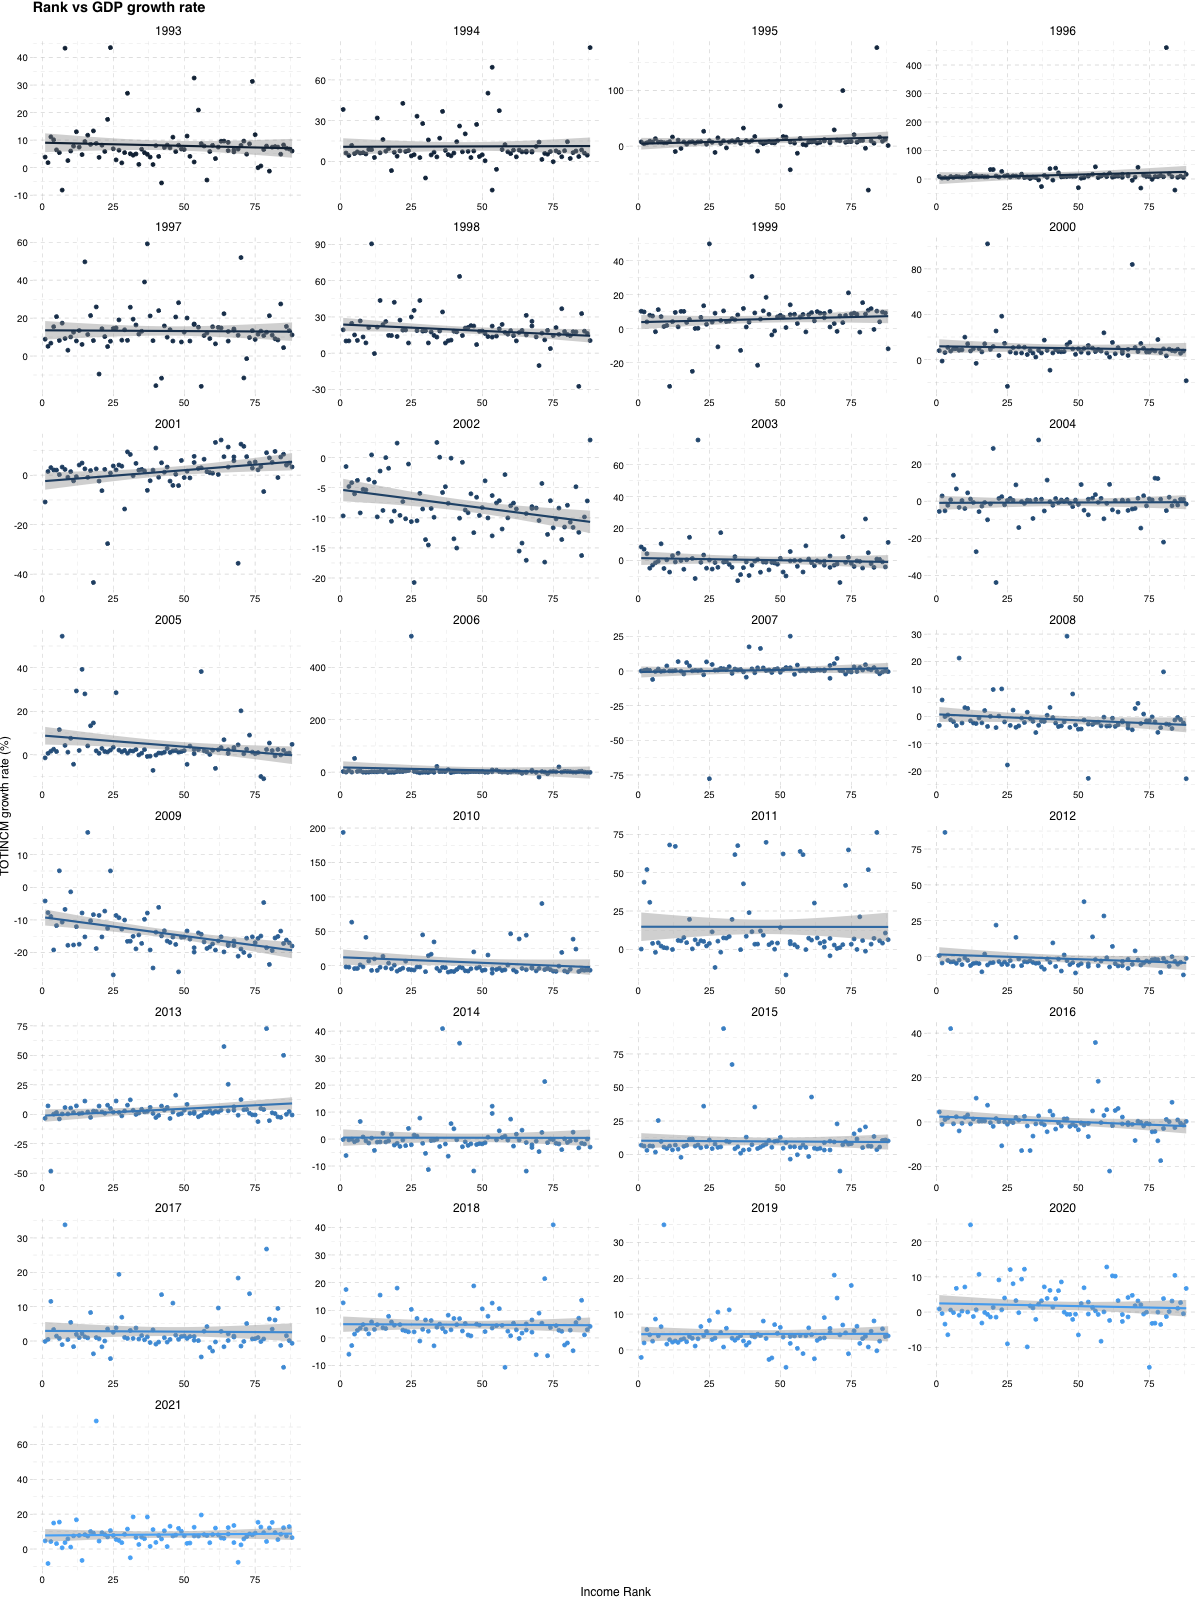

In [123]:
%%R -i df_growth2 -w 1200 -h 1600

library(ggplot2)

ggplot(df_growth2, aes(y = PCT_TOTINCM, x = rank, color= year)) +
    geom_point() +
       geom_smooth(method = 'lm')+
    labs(title = "Rank vs GDP growth rate",
           x = "Income Rank",
           y = "TOTINCM growth rate (%)") +
    theme_pander() +
    facet_wrap(~year, ncol = 4, scale = 'free') +
    theme(legend.position = 'none')

##### Are libraries in richer counties less affected by economic downturn? (using personal income)

In [154]:
personalIncome = pd.read_csv('data/personalIncome.csv')
personalIncome['GeoName'] = personalIncome['GeoName'].str.replace(', OH', '').str.upper()
personalIncome.drop(columns=['GeoFips'], inplace=True)

personalIncome = personalIncome.melt(id_vars=['GeoName'], var_name='year', value_name='income')
personalIncome.year = personalIncome.year.astype(int)

In [165]:
df_growth = compMedInc[['CNTY', 'year', 'PCT_TOTINCM']].merge(personalIncome, left_on=['CNTY', 'year'], right_on=['GeoName', 'year']).drop(columns=['GeoName']).dropna()
df_growth

,CNTY,year,PCT_TOTINCM,income
88,SHELBY,1993,3.821980,904076
89,BELMONT,1993,4.879828,1133605
90,HOCKING,1993,32.554245,420673
91,JACKSON,1993,-0.036713,459152
92,PAULDING,1993,9.637348,338156
...,...,...,...,...
2635,WAYNE,2021,8.264714,6169368
2636,PIKE,2021,9.412727,1243386
2637,MEDINA,2021,3.663314,11735723
2638,SANDUSKY,2021,3.442281,2872650


In [174]:
df_growth['income_rank'] = df_growth.groupby('year')['income'].rank(method='dense', ascending=False)
df_growth.sort_values(by='income_rank')

,CNTY,year,PCT_TOTINCM,income,income_rank
1411,CUYAHOGA,2008,-1.982837,54217026,1.0
2033,CUYAHOGA,2015,1.835678,61323911,1.0
786,CUYAHOGA,2000,9.509721,45411951,1.0
856,CUYAHOGA,2001,0.237062,44849561,1.0
893,CUYAHOGA,2002,-3.779908,44875601,1.0
...,...,...,...,...,...
1197,NOBLE,2005,4.819806,282861,88.0
2345,NOBLE,2018,4.137641,389059,88.0
240,NOBLE,1994,83.753316,163494,88.0
898,VINTON,2002,-7.915680,261834,88.0


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


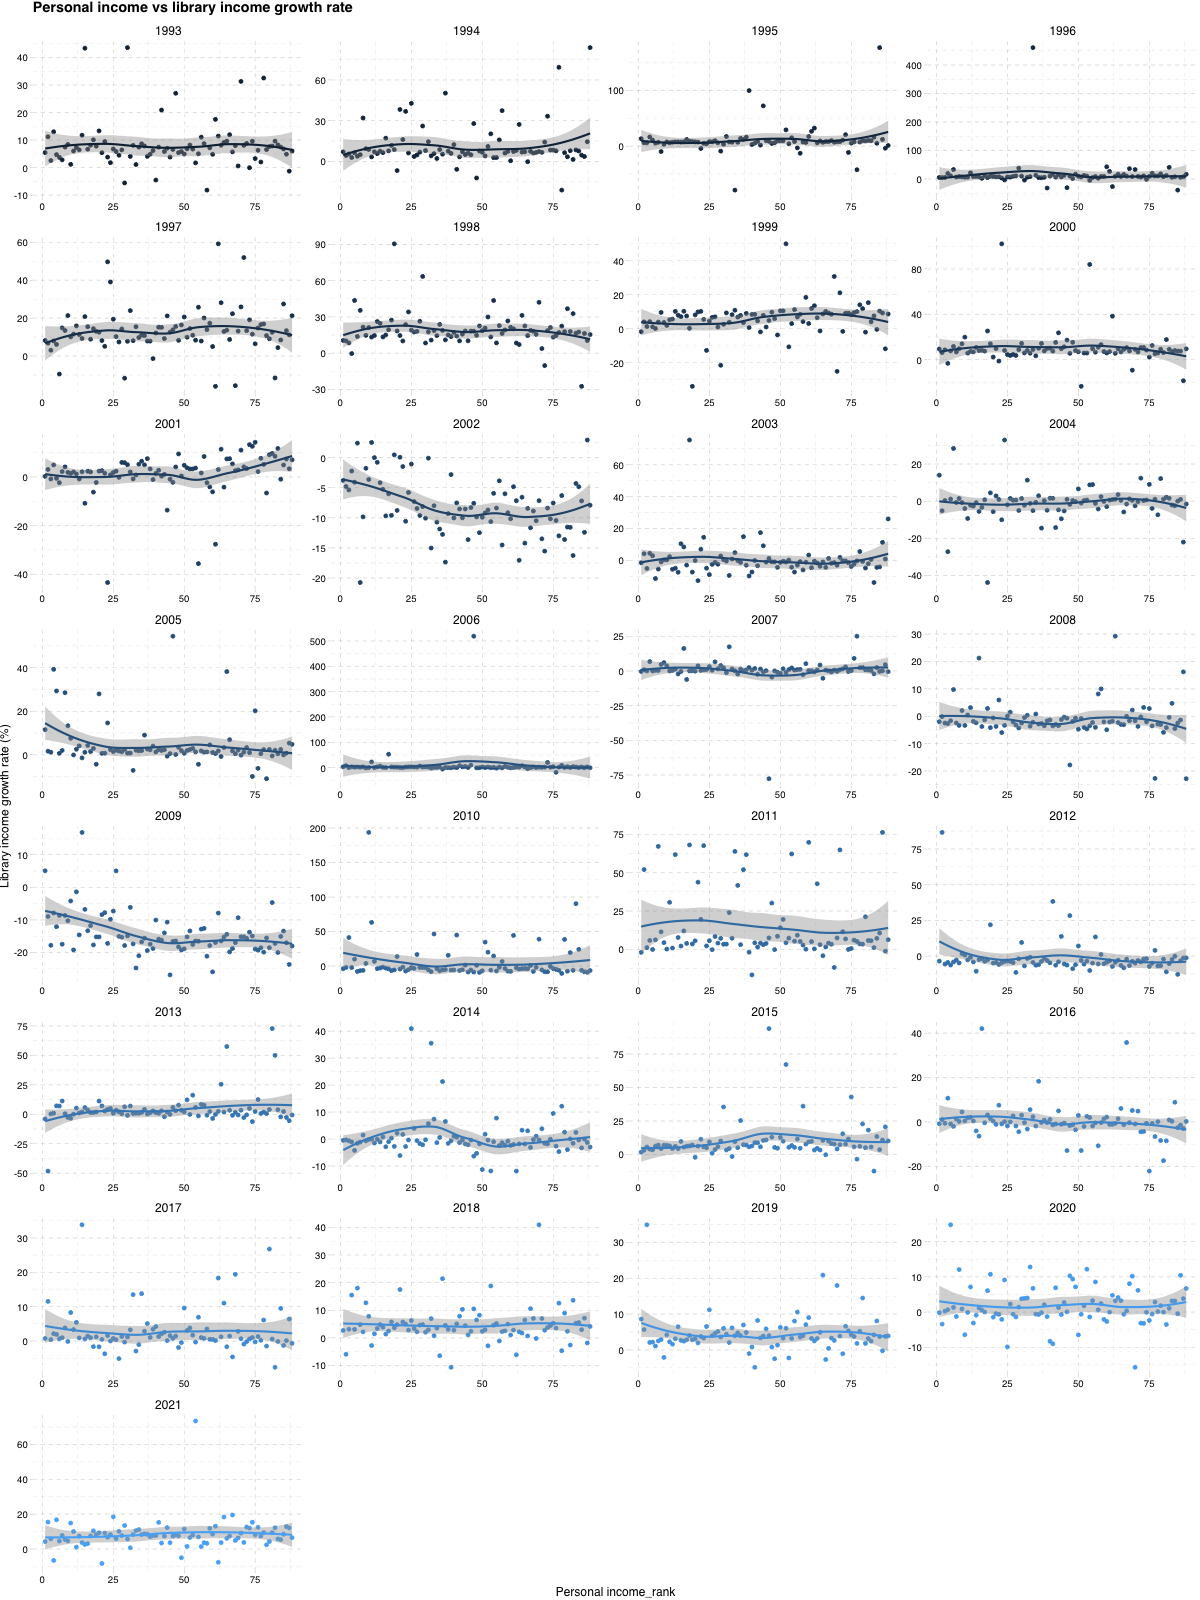

In [175]:
%%R -i df_growth -w 1200 -h 1600

ggplot(df_growth, aes(x = income_rank, y = PCT_TOTINCM, color = year)) +
    geom_point() +
    geom_smooth() +
    labs(title = "Personal income vs library income growth rate",
         x = "Personal income_rank",
         y = "Library income growth rate (%)") +
         facet_wrap(~year, scales = 'free', ncol = 4) +
    theme_pander() +
    theme(legend.position = 'none')

    

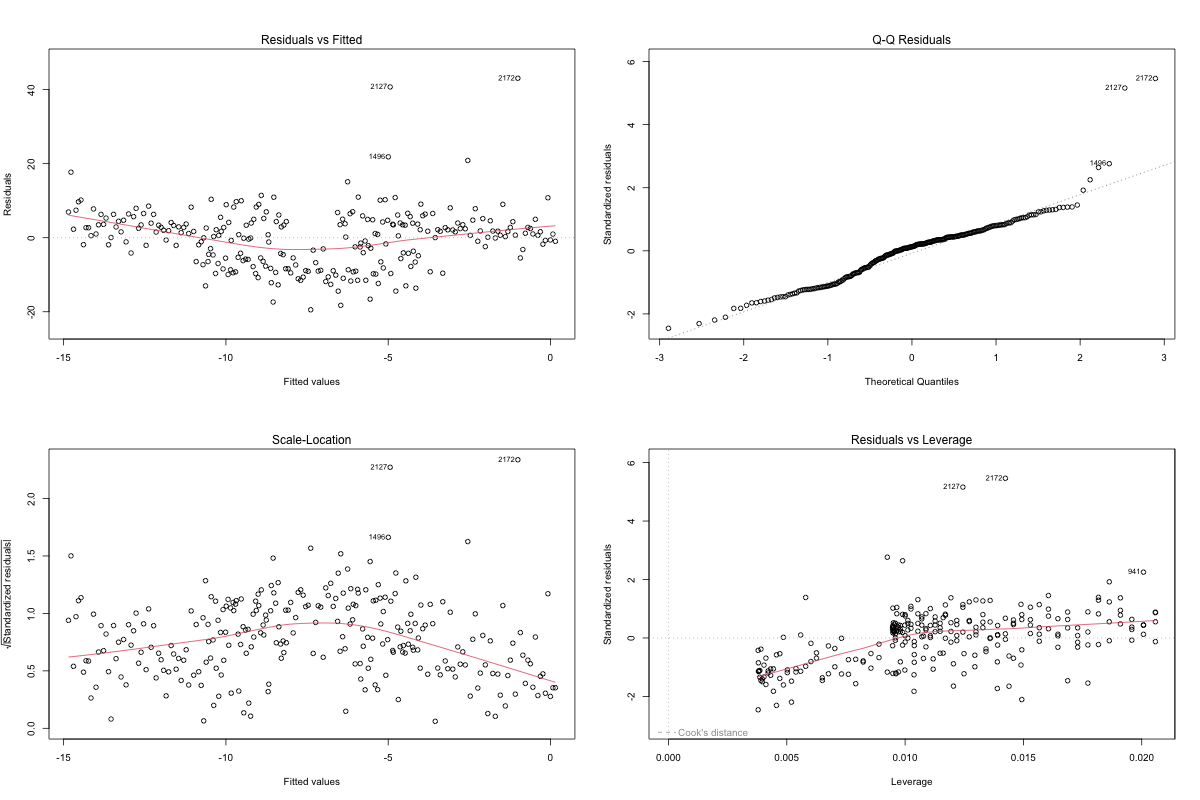

In [776]:
%%R -i df_growth -w 1200 -h 800

# filter for year 2002, 2009, 2016, 2021
df_growth <- df_growth %>% filter(year %in% c(2002, 2009, 2016))

# linear model
model <- lm(PCT_TOTINCM ~ income_rank + year, data = df_growth)
summary(model)

# diagnostic plots
par(mfrow=c(2, 2))
plot(model)

##### Do the libraries with higher per capita incomes have better services?

1. **Collection Size and Diversity**:
   - `BKVOL` - The number of book volumes in the library.
   - `AUDIO` - The number of audio materials (e.g., audiobooks, CDs).
   - `VIDEO` - The number of video materials (e.g., DVDs, Blu-Rays).
   - `SUBSCRIPT` - The number of subscriptions (e.g., periodicals, databases).
   - `EBOOK` - The number of eBooks.
   - `GPTERMS` - The number of computers

2. **Usage Statistics**:
   - `TOTCIR` - Total annual circulation (how many items were checked out during the year).
   - `ATTEND` - Attendance at library programs.
   - `REFERENCE` - The number of reference transactions.
   - `VISITS` - The number of physical visits to the library.
   - `INETUSE` - Usage of internet computers.
   - `WEBVISIT` - Visits to the library’s website.

3. **Programming**:
   - `TOTPRO` - Total number of programs offered by the library.
   - `KIDPRO`, `YAPRO`, `ADULTPRO` - Programs targeted at children, young adults, and adults, respectively.
   - `KIDATTEN`, `YAATTEN`, `ADULTATTEN` - Attendance in programs for children, young adults, and adults.

4. **Technology Access**:
   - `INETACC` - Internet computer access.
   - `WIFISESS` - Wi-Fi sessions.

5. **Staffing**:
   - `LIBRARIAN` - The number of professional librarians.
   - `OTHPAID` - Other paid staff.
   - `TOTPEMP` - Total number of employees.
   
6. **Financial Aspects**:
   - `SALARIES` - Total expenditure on salaries.
   - `BENEFIT` - Benefits expenditure.
   - `CAPITAL` - Expenditures on capital outlays.
   - `TOTEXP` - Total expenditures.

7. **Services Offered**:
   - `LOANTO` and `LOANFM` - Interlibrary loans to and from the library.
   - `KIDCIRCL` - Circulation of children's materials.

8. **Facilities**:
   - `BRANLIB` - Number of branch libraries.
   - `BKMOB` - Number of bookmobiles (if applicable).
   - `HRS_OPEN` - Hours open per week.

In [690]:
OH_df_cnty = OH_df.groupby(['year', 'CNTY'])[['BKVOL','POPU_LSA', 'AUDIO', 'AUDIO_PH','AUDIO_DL', 'VIDEO_PH', 'VIDEO_DL', 'VIDEO','TOTPEMP', 'TOTOPEXP', 'TOTEXP', 'EBOOK', 'GPTERMS', 'LIBRARIA', 'LIBRARIAN', 'TOTSTAFF']].sum().reset_index()

# OH_df_cnty['LIBRARIA'] = OH_df_cnty['LIBRARIAN'].fillna(0) + OH_df_cnty['LIBRARIA'].fillna(0)
OH_df_cnty['AUDIO'] = OH_df_cnty['AUDIO'].fillna(0) + OH_df_cnty['AUDIO_PH'].fillna(0)+ OH_df_cnty['AUDIO_DL'].fillna(0)
OH_df_cnty['VIDEO'] = OH_df_cnty['VIDEO'].fillna(0) + OH_df_cnty['VIDEO_PH'].fillna(0)+ OH_df_cnty['VIDEO_DL'].fillna(0)
OH_df_cnty['TOTSTAFF'] = OH_df_cnty['TOTPEMP'].fillna(0) + OH_df_cnty['TOTSTAFF'].fillna(0)
OH_df_cnty['TOTEXP'] = OH_df_cnty['TOTOPEXP']+ OH_df_cnty['TOTEXP']

OH_df_cnty[['year', 'CNTY', 'POPU_LSA', 'TOTEXP','BKVOL', 'AUDIO', 'VIDEO',  'TOTSTAFF','EBOOK', 'GPTERMS']] 

,year,CNTY,POPU_LSA,TOTEXP,BKVOL,AUDIO,VIDEO,TOTSTAFF,EBOOK,GPTERMS
0,1992,ADAMS,25979.0,262945.0,72604,2761.0,2260.0,49.95,0.0,0.0
1,1992,ALLEN,109446.0,1501181.0,341712,8648.0,3769.0,213.96,0.0,0.0
2,1992,ASHLAND,48111.0,646832.0,131195,3965.0,2994.0,102.96,0.0,0.0
3,1992,ASHTABULA,100405.0,1260883.0,387500,4764.0,7838.0,213.63,0.0,0.0
4,1992,ATHENS,60354.0,457556.0,100378,850.0,1400.0,64.80,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2640,2021,WASHINGTON,61382.0,2665024.0,201219,846655.0,146768.0,33.00,421784.0,56.0
2641,2021,WAYNE,116311.0,6049409.0,370145,989950.0,370704.0,84.81,439137.0,98.0
2642,2021,WILLIAMS,37102.0,2840480.0,126949,1580980.0,125628.0,38.23,843568.0,55.0
2643,2021,WOOD,126163.0,7679345.0,545689,8621290.0,480576.0,95.33,4518087.0,131.0


In [691]:
# name zero columns nan so that they are not included in the calculations
OH_df_cnty[['BKVOL', 'AUDIO', 'VIDEO',  'TOTSTAFF','EBOOK', 'GPTERMS']] = OH_df_cnty[['BKVOL', 'AUDIO', 'VIDEO', 'TOTSTAFF','EBOOK', 'GPTERMS']].replace(0, np.nan)

In [692]:
# per capita for each of the columns
OH_df_cnty['BKVOL_PER_CAPITA'] = OH_df_cnty['BKVOL'] / OH_df_cnty['POPU_LSA']
OH_df_cnty['AUDIO_PER_CAPITA'] = OH_df_cnty['AUDIO'] / OH_df_cnty['POPU_LSA']
OH_df_cnty['VIDEO_PER_CAPITA'] = OH_df_cnty['VIDEO'] / OH_df_cnty['POPU_LSA']
OH_df_cnty['EBOOK_PER_CAPITA'] = OH_df_cnty['EBOOK'] / OH_df_cnty['POPU_LSA']
OH_df_cnty['GPTERMS_PER_CAPITA'] = OH_df_cnty['GPTERMS'] / OH_df_cnty['POPU_LSA']
# OH_df_cnty['LIBRARIA_PER_CAPITA'] = OH_df_cnty['LIBRARIA'] / OH_df_cnty['POPU_LSA']
OH_df_cnty['TOTSTAFF_PER_CAPITA'] = OH_df_cnty['TOTSTAFF'] / OH_df_cnty['POPU_LSA']
OH_df_cnty['TOTEXP_PER_CAPITA'] = OH_df_cnty['TOTEXP'] / OH_df_cnty['POPU_LSA']

In [693]:
OH_df_cnty

,year,CNTY,BKVOL,POPU_LSA,AUDIO,AUDIO_PH,AUDIO_DL,VIDEO_PH,VIDEO_DL,VIDEO,...,LIBRARIA,LIBRARIAN,TOTSTAFF,BKVOL_PER_CAPITA,AUDIO_PER_CAPITA,VIDEO_PER_CAPITA,EBOOK_PER_CAPITA,GPTERMS_PER_CAPITA,TOTSTAFF_PER_CAPITA,TOTEXP_PER_CAPITA
0,1992,ADAMS,72604,25979.0,2761.0,0.0,0.0,0.0,0.0,2260.0,...,75.00,15.00,49.95,2.794719,0.106278,0.086993,NaN,NaN,0.001923,10.121444
1,1992,ALLEN,341712,109446.0,8648.0,0.0,0.0,0.0,0.0,3769.0,...,70.00,14.00,213.96,3.122197,0.079016,0.034437,NaN,NaN,0.001955,13.716180
2,1992,ASHLAND,131195,48111.0,3965.0,0.0,0.0,0.0,0.0,2994.0,...,52.50,10.50,102.96,2.726923,0.082414,0.062231,NaN,NaN,0.002140,13.444576
3,1992,ASHTABULA,387500,100405.0,4764.0,0.0,0.0,0.0,0.0,7838.0,...,113.95,22.79,213.63,3.859370,0.047448,0.078064,NaN,NaN,0.002128,12.557970
4,1992,ATHENS,100378,60354.0,850.0,0.0,0.0,0.0,0.0,1400.0,...,50.00,10.00,64.80,1.663154,0.014084,0.023196,NaN,NaN,0.001074,7.581204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,2021,WASHINGTON,201219,61382.0,846655.0,15500.0,153831.0,32799.0,3893.0,146768.0,...,9.25,0.00,33.00,3.278143,13.793213,2.391059,6.871461,0.000912,0.000538,43.417028
2641,2021,WAYNE,370145,116311.0,989950.0,30914.0,167076.0,51632.0,41044.0,370704.0,...,21.81,0.00,84.81,3.182373,8.511233,3.187179,3.775541,0.000843,0.000729,52.010635
2642,2021,WILLIAMS,126949,37102.0,1580980.0,8534.0,307662.0,23621.0,7786.0,125628.0,...,15.60,0.00,38.23,3.421621,42.611719,3.386017,22.736456,0.001482,0.001030,76.558676
2643,2021,WOOD,545689,126163.0,8621290.0,34388.0,1689870.0,75131.0,45013.0,480576.0,...,29.73,0.00,95.33,4.325270,68.334535,3.809168,35.811506,0.001038,0.000756,60.868440


In [715]:
from sklearn.preprocessing import StandardScaler

per_capita_cols = ['BKVOL_PER_CAPITA', 'AUDIO_PER_CAPITA', 'VIDEO_PER_CAPITA', 'EBOOK_PER_CAPITA',
                   'GPTERMS_PER_CAPITA', 'TOTSTAFF_PER_CAPITA']

# standard deviation and the mean for per_capita_cols
scaler = StandardScaler() 

# z-scores
OH_df_cnty[per_capita_cols] = scaler.fit_transform(OH_df_cnty[per_capita_cols])

# standardized score: sum of the z-scores
OH_df_cnty['STANDARDIZED_SCORE'] = OH_df_cnty[per_capita_cols].mean(axis=1)
OH_df_cnty

,year,CNTY,BKVOL,POPU_LSA,AUDIO,AUDIO_PH,AUDIO_DL,VIDEO_PH,VIDEO_DL,VIDEO,...,LIBRARIAN,TOTSTAFF,BKVOL_PER_CAPITA,AUDIO_PER_CAPITA,VIDEO_PER_CAPITA,EBOOK_PER_CAPITA,GPTERMS_PER_CAPITA,TOTSTAFF_PER_CAPITA,TOTEXP_PER_CAPITA,STANDARDIZED_SCORE
0,1992,ADAMS,72604,25979.0,2761.0,0.0,0.0,0.0,0.0,2260.0,...,15.00,49.95,-0.704656,-0.416896,-0.331084,NaN,NaN,1.006251,10.121444,-0.111596
1,1992,ALLEN,341712,109446.0,8648.0,0.0,0.0,0.0,0.0,3769.0,...,14.00,213.96,-0.459529,-0.418178,-0.344834,NaN,NaN,1.041334,13.716180,-0.045302
2,1992,ASHLAND,131195,48111.0,3965.0,0.0,0.0,0.0,0.0,2994.0,...,10.50,102.96,-0.755403,-0.418018,-0.337563,NaN,NaN,1.242836,13.444576,-0.067037
3,1992,ASHTABULA,387500,100405.0,4764.0,0.0,0.0,0.0,0.0,7838.0,...,22.79,213.63,0.092265,-0.419663,-0.333420,NaN,NaN,1.229373,12.557970,0.142139
4,1992,ATHENS,100378,60354.0,850.0,0.0,0.0,0.0,0.0,1400.0,...,10.00,64.80,-1.551663,-0.421232,-0.347775,NaN,NaN,0.082046,7.581204,-0.559656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,2021,WASHINGTON,201219,61382.0,846655.0,15500.0,153831.0,32799.0,3893.0,146768.0,...,0.00,33.00,-0.342799,0.226860,0.271723,-0.071312,-0.037344,-0.501458,43.417028,-0.075722
2641,2021,WAYNE,370145,116311.0,989950.0,30914.0,167076.0,51632.0,41044.0,370704.0,...,0.00,84.81,-0.414486,-0.021575,0.480010,-0.332165,-0.170498,-0.292951,52.010635,-0.125278
2642,2021,WILLIAMS,126949,37102.0,1580980.0,8534.0,307662.0,23621.0,7786.0,125628.0,...,0.00,38.23,-0.235402,1.582319,0.532031,1.265427,1.050934,0.034953,76.558676,0.705044
2643,2021,WOOD,545689,126163.0,8621290.0,34388.0,1689870.0,75131.0,45013.0,480576.0,...,0.00,95.33,0.441004,2.792175,0.642739,2.367092,0.203226,-0.264166,60.868440,1.030345


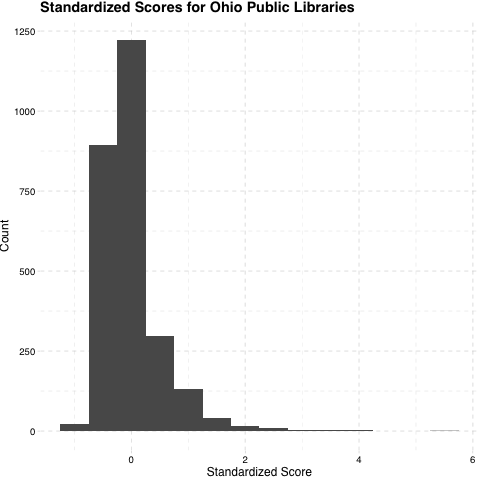

In [716]:
%%R -i OH_df_cnty 

# histogram of standardized scores
ggplot(OH_df_cnty, aes(x = STANDARDIZED_SCORE)) +
    geom_histogram(binwidth = 0.5) +
    labs(title = "Standardized Scores for Ohio Public Libraries",
         x = "Standardized Score",
         y = "Count") +
    theme_pander()

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


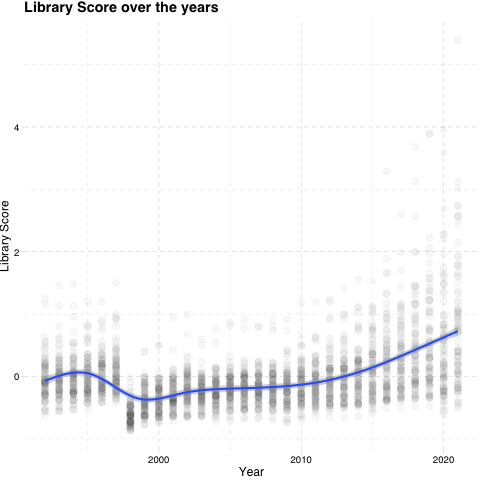

In [717]:
%%R -i OH_df_cnty 
ggplot(OH_df_cnty, aes(x = year, y = STANDARDIZED_SCORE)) +
    geom_point(size = 3, alpha = 0.03) +
    geom_smooth() +
    labs(title = "Library Score over the years",
         x = "Year",
         y = "Library Score") +
    theme_pander() +
    theme(legend.position = 'none')


Family: gaussian 
Link function: identity 

Formula:
log(STANDARDIZED_SCORE) ~ s(log(TOTEXP_PER_CAPITA)) + s(year)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.22652    0.04438  -27.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                            edf Ref.df       F  p-value    
s(log(TOTEXP_PER_CAPITA)) 4.258  5.254   4.942 0.000176 ***
s(year)                   1.128  1.245 170.984  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.286   Deviance explained = 29.2%
GCV = 1.3128  Scale est. = 1.3001    n = 660
[[1]]
[[1]]$x
  [1] 3.167327 3.184103 3.200878 3.217653 3.234428 3.251203 3.267979 3.284754
  [9] 3.301529 3.318304 3.335080 3.351855 3.368630 3.385405 3.402181 3.418956
 [17] 3.435731 3.452506 3.469281 3.486057 3.502832 3.519607 3.536382 3.553158
 [25] 3.569933 3.586708 3.603483 3.620259 3.637034 3

In addition: Warning messages:
1: In log(STANDARDIZED_SCORE) : NaNs produced
2: In log(STANDARDIZED_SCORE) : NaNs produced


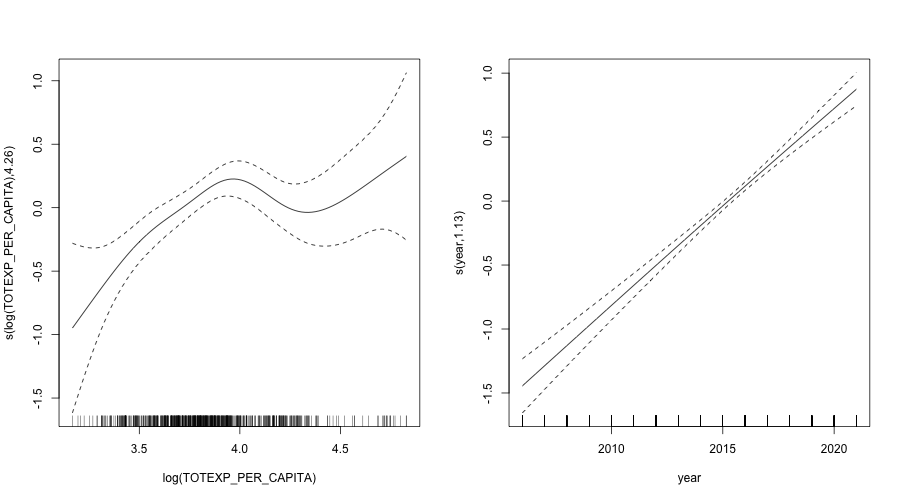

In [758]:
%%R -i OH_df_cnty -w 900 -h 500 -o OH_df_cnty

library(mgcv)

# filter out the year 2021
# OH_df_cnty <- OH_df_cnty %>% filter(year > 2005)


gam_model <- gam(log(STANDARDIZED_SCORE) ~ s(log(TOTEXP_PER_CAPITA)) + s(year), data = OH_df_cnty)

print(summary(gam_model))

print(plot(gam_model, pages = 1, scale = 0))


# diagnostic plots
# simulationOutput <- simulateResiduals(fittedModel = gam_model)
# print(plot(simulationOutput))
# testResiduals(simulationOutput)



`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


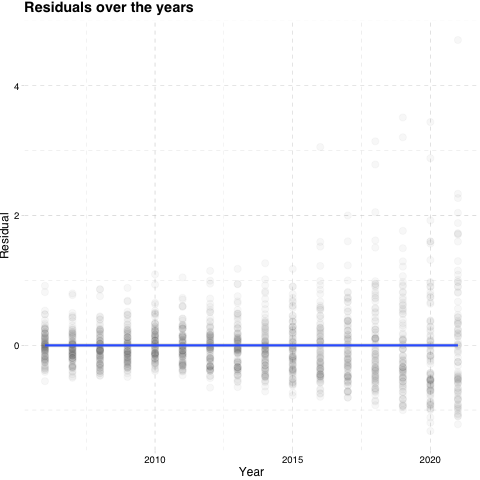

In [748]:
%%R -i OH_df_cnty 

ggplot(OH_df_cnty, aes(x = year, y = residual)) +
    geom_point(size = 3, alpha = 0.03) +
    geom_smooth() +
    labs(title = "Residuals over the years",
         x = "Year",
         y = "Residual") +
    theme_pander() +
    theme(legend.position = 'none')